# Import libraries

In [1]:
# Reload modules
%load_ext autoreload
%autoreload 2
# Inline plots
%matplotlib inline

# Standard
import numpy as np
import matplotlib.pyplot as plt
import time as time
from copy import deepcopy

# tf
import tensorflow as tf
from tensorflow.examples.tutorials.mnist import input_data

# Mine
from utility import display_image, permutate # Utilities
from model import Net   # Model definition
from train import train # Training code

# Set parameters

In [13]:
# Set random seed
num_seed = 1
tf.set_random_seed(num_seed)

# Training
N_task = 20       # Number of tasks
N_it = 6000       # Number of iterations
batch_size = 100 # Number of samples in each minibatch
alpha = 0.01     # Learning rate
optim_type = 0   # 0 = GradientDescentOptimizer, 1 = AdamOptimizer

# Network
hidden_size = 50       # Number of hidden layer neurons

# Regularization and Fisher
lambda_L2 = 0.05        # Regularization parameter for L2
lambda_EWC = 15         # Regularization parameter for EWC
sample_size_Fish = 200 # Number of samples to use to estimate Fisher Info.

# Miscellaneous
ep_rec = 20            # Record test accuracy every ep_rec iterations
ep_time = int(N_it/1) # Display time every ep_time iterations
save_plots = True

# Load data

In [3]:
# Extract dataset
dataset = input_data.read_data_sets('MNIST_data', one_hot=True)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz


# Create permutated datasets

In [4]:
datasets = [dataset] # List of datasets

# Append permuted datasets
for i in range(N_task-1):
    datasets.append(permutate(dataset))

# Plot sample images

label = 0


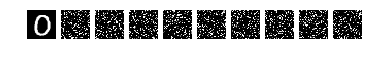

In [5]:
sample_index = 10      # Sample image to display
# Display label
label = datasets[0].train.labels[sample_index]
label = np.nonzero(label)[0][0]
print('label = ' + str(label))

# Display images
plt.figure()
for i in range(N_task):
    image = datasets[i].train.images[sample_index]

    plt.subplot(1,N_task,1+i)
    display_image(image)

# Create models

In [6]:
sess = tf.InteractiveSession() # Initialize session
# input and output placeholders
input_dim = datasets[0].train.images.shape[1]
output_dim = datasets[0].train.labels.shape[1]
inputs = tf.placeholder(tf.float32, shape=[None,input_dim])
labels = tf.placeholder(tf.float32, shape=[None,output_dim])

# Instantiate models
tf.set_random_seed(num_seed)
model = Net(inputs,labels,hidden_dim=50)
tf.set_random_seed(num_seed)
model_L2 = Net(inputs,labels,hidden_dim=50)
tf.set_random_seed(num_seed)
model_EWC = Net(inputs,labels,hidden_dim=50)

# Model set
model.set_vanilla(alpha,optim_type)
model_L2.set_L2(alpha,optim_type)
model_EWC.set_EWC(alpha,optim_type)
model_EWC.set_Fisher()

# Initialize variables
sess.run(tf.global_variables_initializer())

# Train

In [7]:
# Initialize test accuracy lists
test_acc_lists = []
test_acc_lists_L2 = []
test_acc_lists_EWC = []
for i in range(N_task):
    test_acc_lists.append(np.zeros([0]))
    test_acc_lists_L2.append(np.zeros([0]))
    test_acc_lists_EWC.append(np.zeros([0]))

time_start = time.time()
time_p1 = time.time()
break_signal = False
print('------------------------------------------------------------')
for i in range(N_task):

    print('Task ' + str(i))
    print('------------------------------------------------------------')
        
    # Vanilla
    #model.set_vanilla(alpha)
    test_acc_list,_ = train(sess,model,datasets[i],datasets,inputs,labels,N_it,batch_size,ep_rec,ep_time,'Vanilla')
    # L2
    #model_L2.set_L2(alpha,lambda_L2)
    test_acc_list_L2,_ = train(sess,model_L2,datasets[i],datasets,inputs,labels,N_it,batch_size,ep_rec,ep_time,'L2')
    # EWC
    #model_EWC.set_EWC(alpha,lambda_EWC)
    '''
    a = 0
    for j in range(len(model_EWC.params)):
        a += model_EWC.params[j].eval().sum()
    print('params_before', a)
    
    print('loss_before', model_EWC.loss_EWC.eval(feed_dict={inputs: datasets[i].train.images,labels:datasets[i].train.labels}))
    '''
    test_acc_list_EWC,bat = train(sess,model_EWC,datasets[i],datasets,inputs,labels,N_it,batch_size,ep_rec,ep_time,'EWC',i)
    '''
    print('loss_after', model_EWC.loss_EWC.eval(feed_dict={inputs: datasets[i].train.images,labels:datasets[i].train.labels}))
    
    a = 0
    for j in range(len(model_EWC.params)):
        a += model_EWC.params[j].eval().sum()
    print('params_after', a)

    if a!=a:
        print('nan parameters')
        print('Error-----------------------------------------------------')
        break;
    '''
    
    time_F1 = time.time()
    # Compute Fisher Info.
    model_EWC.compute_Fisher(datasets[i].validation.images,sess,sample_size_Fish)
    time_F2 = time.time()
    print('Fisher computation runtime: ' + str(time_F2-time_F1) + ' s')
    
    # Save parameters
    model_L2.save_parameters()
    model_EWC.save_parameters()
    
    # Update loss functions
    model_L2.update_L2(lambda_L2)
    model_EWC.update_EWC(lambda_EWC)
    
    for F in model_EWC.Fisher:
        blah2 = F.sum()
        if blah2 != blah2:
            break_signal = True
            
    '''
    if break_signal:
        print('nan Fisher')
        print('Error-----------------------------------------------------')
        break;
    '''
    
    
    # Record test accuracies
    for j in range(N_task):
        test_acc_lists[j] = np.hstack([test_acc_lists[j],test_acc_list[j]])
        test_acc_lists_L2[j] = np.hstack([test_acc_lists_L2[j],test_acc_list_L2[j]])
        test_acc_lists_EWC[j] = np.hstack([test_acc_lists_EWC[j],test_acc_list_EWC[j]])
    
    time_p2 = time.time()
    print('Total runtime for task ' + str(i) + ': ' + str(time_p2-time_p1) + ' s')
    time_p1 = time_p2
    
    print('------------------------------------------------------------')
time_finish = time.time()  
print('Total runtime: ' + str(time_finish-time_start) + ' s')


------------------------------------------------------------
Task 0
------------------------------------------------------------
Vanilla training runtime: 46.91476130485535 s
L2 training runtime: 46.77066373825073 s
EWC training runtime: 46.72598648071289 s
Fisher computation runtime: 0.1949467658996582 s
Total runtime for task 0: 140.81193041801453 s
------------------------------------------------------------
Task 1
------------------------------------------------------------
Vanilla training runtime: 46.94773769378662 s
L2 training runtime: 47.84285640716553 s
EWC training runtime: 48.1182701587677 s
Fisher computation runtime: 0.19039273262023926 s
Total runtime for task 1: 143.45437622070312 s
------------------------------------------------------------
Task 2
------------------------------------------------------------
Vanilla training runtime: 47.26441025733948 s
L2 training runtime: 49.315940380096436 s
EWC training runtime: 49.864405155181885 s
Fisher computation runtime: 0.20

In [8]:
model_EWC.loss_EWC.eval(feed_dict={inputs: datasets[i].train.images,labels:datasets[i].train.labels})

1.9172664

In [9]:
for i in range(len(model_EWC.params_prev)):
    print(np.mean(model_EWC.Fisher[i]))

0.00234302096307
0.0225129557622
0.110612953289
0.0422037049356


# Plot

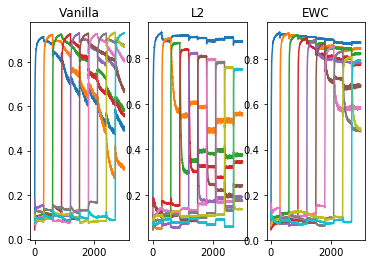

In [14]:
plt.figure()

plt.subplot(1,3,1)
plt.title('Vanilla')
plt.subplot(1,3,2)
plt.title('L2')
plt.subplot(1,3,3)
plt.title('EWC')
for i in range(N_task):
    plt.subplot(1,3,1)
    plt.plot(test_acc_lists[i],label='Task ' + str(i))
    plt.subplot(1,3,2)
    plt.plot(test_acc_lists_L2[i],label='Task ' + str(i))
    plt.subplot(1,3,3)
    plt.plot(test_acc_lists_EWC[i],label='Task ' + str(i))
if save_plots:
    title = 'N_task='+str(N_task)+'_N_it='+str(N_it)+'_lr='+str(alpha)+'_lamb_L2='+str(lambda_L2)+'_lamb_EWC='+str(lambda_EWC)+'_seed='+str(num_seed)+'.png'
    if optim_type:
        title = 'Adam_' + title
    plt.savefig(title)
plt.show()

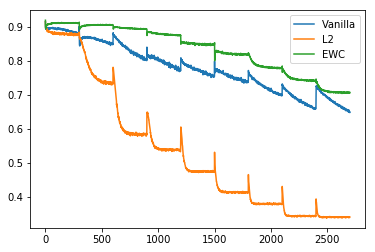

In [16]:
# Task-averaged accuracy (only on trained tasks)
num_points = int(N_it/ep_rec) # Number of data points per task

test_acc_avg = np.zeros((N_task-1)*num_points)
test_acc_avg_L2 = np.zeros((N_task-1)*num_points)
test_acc_avg_EWC = np.zeros((N_task-1)*num_points)

for i in range(1,N_task):
    for j in range(i): # Only range over trained tasks
        test_acc_avg[(i-1)*num_points:i*num_points] += test_acc_lists[j][i*num_points:(i+1)*num_points]
        test_acc_avg_L2[(i-1)*num_points:i*num_points] += test_acc_lists_L2[j][i*num_points:(i+1)*num_points]
        test_acc_avg_EWC[(i-1)*num_points:i*num_points] += test_acc_lists_EWC[j][i*num_points:(i+1)*num_points]
    test_acc_avg[(i-1)*num_points:i*num_points] /= i
    test_acc_avg_L2[(i-1)*num_points:i*num_points] /= i
    test_acc_avg_EWC[(i-1)*num_points:i*num_points] /= i
        
plt.plot(test_acc_avg, label='Vanilla')
plt.plot(test_acc_avg_L2, label='L2')
plt.plot(test_acc_avg_EWC, label='EWC')
plt.legend()
if save_plots:
    title = 'N_task='+str(N_task)+'_N_it='+str(N_it)+'_lr='+str(alpha)+'_lamb_L2='+str(lambda_L2)+'_lamb_EWC='+str(lambda_EWC)+'_seed='+str(num_seed)+'.png'
    if optim_type:
        title = 'Adam_' + title
    plt.savefig('title')
plt.show()

# Jot notes

In [12]:
print(model_EWC.loss_EWC.eval(feed_dict={inputs: datasets[2].train.images,outputs:datasets[2].train.labels}))

NameError: name 'outputs' is not defined

In [ ]:
model_EWC.load_parameters(sess)
model_EWC.params[1].eval().sum()
#model_EWC.loss_EWC = model_EWC.loss_vanilla

In [ ]:
#test_acc_list_EWC = train(sess,model_EWC,datasets[4],datasets,inputs,outputs,N_it,batch_size,1,lambda_EWC,ep_rec,ep_time)

In [ ]:
i_data=0
probs = tf.nn.softmax(model_EWC.outputs)
a = tf.multinomial(tf.log(probs),1)[0][0]
sess.run(probs,feed_dict={model_EWC.x:datasets[i].validation.images[i_data:i_d
                                                                    ata+1]})

In [ ]:
print(model_EWC.loss_EWC.eval(feed_dict={inputs: datasets[6].train.images,outputs:datasets[6].train.labels}))

In [ ]:
a = 0
for i in range(4):
    print(np.sum(model_EWC.params_prev[i]**2))

In [ ]:
a = []
for i in range(model_EWC.params_prev[0].shape[0]):
    a.append(model_EWC.params_prev[0][i].sum())
#model_EWC.params_prev[2][30
sum(a)

In [ ]:
a = 0
for i in range(len(model_EWC.params)):
    a+=model_EWC.params[i].eval().sum()

In [ ]:
max(a)